## MountainCarContinuous-v0 Question: 

### Observation

观测值，即智能体的状态，包括位置和速度，具体取值范围如下：  
位置：-1.2 —— 0.6  
速度：-0.07 —— 0.07

### Actions

智能体的行为：向左或向右一定的距离或不动。这里的距离是连续的值，需要对其进行离散化

### Reward

回报是达到右边山上的目标点为100，再减去从开始到目标的行动的平方和。
此回报函数提出了一个探索挑战，如果代理不能很快到达目标，它会发现最好不要移动，也不会再找到目标。

### Starting State

位置为0.5，速度为0

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model

In [2]:
#导入模型，MountainCarContinuous问题
env = gym.make("MountainCarContinuous-v0")
env.reset()

array([-0.44010837,  0.        ])

# Parameter

In [4]:
#基本参数
alpha = 0.5 #学习率
gama = 0.95 #折现因子
episodes_num = 5000 #训练轮数
display_num = 200 #训练时每隔多少轮显示进度
Qtable_size = 200 #Q表的长度

#离散化参数
#行动
action_space = np.array(range(-10,11,4))/10. #从-1到1分为6份
action_space = action_space.reshape(len(action_space),1) #适应环境需要进行reshape
#状态
discrete_size = [Qtable_size] * len(env.observation_space.high) #200*200
discrete_step = (env.observation_space.high - env.observation_space.low) / discrete_size #单位步长
q_table = np.random.uniform(low=0, high=1,size=(discrete_size + [len(action_space)])) #Q表初始化，大小：200*200*6

#ε参数
#初始为１，后续随训练轮数逐渐减小
epsilon = 1
start_episode = 1
end_episode = episodes_num//2
#每步递减值
de_step = epsilon/(end_episode - start_episode)

# Auxiliary Function

In [5]:
#帮助函数
#离散化状态——将连续的状态变位离散的状态
def get_discrete_state (state):
    discrete_state = (state - env.observation_space.low) // discrete_step
    return tuple(discrete_state.astype(int))

#ε—贪心策略执行行动。注：这里的行动由index指向action_space中的具体行为
def take_epilon_greedy_action(state, epsilon):
    discrete_state = get_discrete_state(state)
    if np.random.random() < epsilon:
        action_indx = np.random.randint(0,len(action_space))
    else:
        action_indx = np.argmax(q_table[discrete_state])
    return action_indx, action_space[action_indx]

#  Storage

In [6]:
#回报存储
ep_rewards = []
aggr_ep_rewards = {'ep':[],'avg':[],'min':[],'max':[]}

# Train

In [11]:
for episode in range(episodes_num):
    # initiate reward every episode
    ep_reward = 0
    if episode % display_num == 0:
        print("episode: {}".format(episode))
        render = True
    else:
        render = False

    state = env.reset()
    #At
    action_indx, action = take_epilon_greedy_action(state, epsilon)
    done = False
    while not done:
        #St，At——St+1
        next_state, reward, done, _ = env.step(action)
        #回报累计
        ep_reward += reward
        #St+1——At+1
        next_action_indx, next_action = take_epilon_greedy_action(next_state, epsilon)

        # if render:
        #     env.render()
        
        #未结束
        if not done:
            #ε-贪心策略决定At+1
            td_target = reward + gama * q_table[get_discrete_state(next_state)][next_action_indx]
            #更新Q(St，At)
            q_table[get_discrete_state(state)][action_indx] += alpha * (td_target - q_table[get_discrete_state(state)][action_indx])
        
        #到达目标点，结束
        elif next_state[0] >= 0.5:
            # print("I made it on episode: {} Reward: {}".format(episode,reward))
            q_table[get_discrete_state(state)][action_indx] = 0
        
        #状态迭代
        state = next_state
        action = next_action
        action_indx = next_action_indx

    # ε值的递减
    if end_episode >= episode >= start_episode:
        epsilon -= de_step

    # 每轮回报值的存储
    ep_rewards.append(ep_reward)

    # 每个SHOW_EVERY轮显示并存储数据
    if episode % display_num == 0:
        avg_reward = sum(ep_rewards[-display_num:]) / len(ep_rewards[-display_num:])
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(avg_reward)
        aggr_ep_rewards['min'].append(min(ep_rewards[-display_num:]))
        aggr_ep_rewards['max'].append(max(ep_rewards[-display_num:]))

episode: 0
episode: 200
episode: 400
episode: 600
episode: 800
episode: 1000
episode: 1200
episode: 1400
episode: 1600
episode: 1800
episode: 2000
episode: 2200
episode: 2400
episode: 2600
episode: 2800
episode: 3000
episode: 3200
episode: 3400
episode: 3600
episode: 3800
episode: 4000
episode: 4200
episode: 4400
episode: 4600
episode: 4800


# Display Rewards

Text(0, 0.5, 'Rewards')

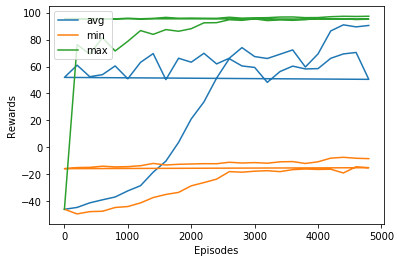

In [12]:
#回报展示
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label = 'avg')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label = 'min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label = 'max')
plt.legend(loc='upper left')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

# Test

In [18]:
#训练结果测试
done = False
state = env.reset()
while not done:
    action_indx = np.argmax(q_table[get_discrete_state(state)])
    next_state, _, done, _ = env.step(action_space[action_indx])
    state = next_state
    env.render()

env.close()